In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy
from matplotlib.offsetbox import AnchoredText
import cartopy.feature as cfeature
import scipy.fft as sf
from scipy import signal


In [ ]:
### For Narwhal ###
data_dir = '/data/deluge/scratch/ERA5/2D/daily/precip/'
    

In [9]:
"""
Funtion that calculates the Fourier coefficients and the explained variance of the Nth
first harmonics of a time series
Input:
   tseries: input time series
   nmodes : number of harmonics to retain (N)
   coefa  : Array with N (or 'nmodes') elements
   coefb  : Array with N (or 'nmodes') elements
   hvar   : Array with N (or 'nmodes') elements
   missval: Falg value for missing data
Output:
   coefa: Array of A coefficients of the Nth first harmonics
   coefb: Array of B coefficients of the Nth first harmonics
   hvar : Array of explained variance of the Nth first harmonics
"""
def Harmonics(ds,nmodes=2,missval=np.nan):
    import sys
    import numpy as np
    from scipy.stats import norm
    #import netCDF4 as nc
    import math
    from datetime import timedelta, date
    tseries = ds
    mtot=len(tseries)
    time=np.arange(1,mtot+1,1.)
    newdim=len(tseries[tseries!=missval])  # removing missing data
    time=time[tseries!=missval]
    tdata=tseries[tseries!=missval]
    svar=sum((tdata[:]-np.mean(tdata))**2)/(newdim-1)
    nm=nmodes
    if 2*nm > newdim:
       nm=newdim/2
    coefa=np.zeros((nm))
    coefb=np.zeros((nm))
    hvar=np.zeros((nm))
    for tt in range(0,nm):
        Ak=np.sum(tdata[:]*np.cos(2.*math.pi*(tt+1)*time[:]/float(newdim)))
        Bk=np.sum(tdata[:]*np.sin(2.*math.pi*(tt+1)*time[:]/float(newdim)))
        coefa[tt]=Ak*2./float(newdim)
        coefb[tt]=Bk*2./float(newdim)
        hvar[tt]=newdim*(coefa[tt]**2+coefb[tt]**2)/(2.*(newdim-1)*svar)
    return hvar.argmax()+1

In [2]:
ds = xr.open_dataset('ERA5_precip_2009.nc')

In [3]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 141, latitude: 241, time: 26304)
Coordinates:
  * longitude  (longitude) float32 -120.0 -119.8 -119.5 ... -85.5 -85.25 -85.0
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... 30.5 30.25 30.0
  * time       (time) datetime64[ns] 2008-01-01 ... 2010-12-31T23:00:00
Data variables:
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-09-22 17:41:16 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

In [4]:
precip = ds['tp']*1000.0

In [5]:
### Create Daily precip from hourly ###
daily_precip = precip.resample(time='1D').sum()

In [6]:
### Create The annual daily precip anomalies ###
annual_means = daily_precip.groupby('time.year').mean(dim='time')

anomalies_withleap = daily_precip.groupby('time.year') - annual_means
anomalies = anomalies_withleap.sel(time=~((anomalies_withleap.time.dt.month == 2) & (anomalies_withleap.time.dt.day == 29)))

In [ ]:
num_wetseasons

In [10]:



for i, k in anomalies.groupby('time.year'):
    wetseason = xr.apply_ufunc(
    Harmonics,
    k,
    input_core_dims=[["time"]],
    exclude_dims=set(["time"]),
    vectorize=True,
    )

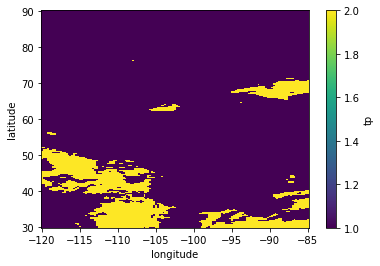

In [12]:
wetseason.plot()

In [255]:
y = test4.rolling(window=15,min_periods=5).mean().cumsum().to_numpy()[4:]

In [263]:
harm_test = Harmonics(tseries=test.isel(latitude=100, longitude=100),nmodes=3, missval=np.nan)

In [266]:
harm_test[2].argmax()

2

In [8]:
def bower_wetseason(x):
    x = pd.Series(x)
    wet_season = x.rolling(window=5,min_periods=5).mean().cumsum().idxmin() + 1
    return wet_season
        
    

In [ ]:
# function that takes arguments of unequal length and requires vectorizing
def theil_senn(y):
    result = stats.theilslopes(y,x=np.arange(len(y)),alpha=0.95)
    slope = result[0]
    max_slope = result[3]
    min_slope = result[2]
    if min_slope <= 0 <= max_slope: 
        return np.nan
    else:
        return slope 

In [271]:
wetseason = xr.apply_ufunc(
    Harmonics,
    test,
    input_core_dims=[["time"]],
    exclude_dims=set(["time"]),
    vectorize=True,
)

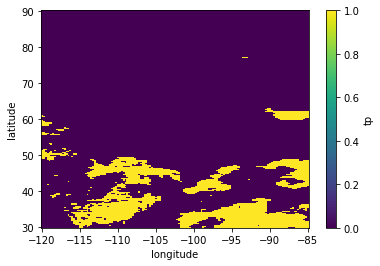

In [273]:
wetseason.plot()

In [19]:
wetseason = wetseason.sel(latitude=slice(60,30))

In [21]:
wetseason

<xarray.DataArray 'tp' (latitude: 121, longitude: 141)>
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2]])
Coordinates:
  * longitude  (longitude) float32 -120.0 -119.8 -119.5 ... -85.5 -85.25 -85.0
  * latitude   (latitude) float32 60.0 59.75 59.5 59.25 ... 30.5 30.25 30.0

In [11]:
levels = np.arange(0,365,15)

In [17]:
levels = [1,2,3]

In [27]:
p.axes

<GeoAxesSubplot:xlabel='longitude', ylabel='latitude'>

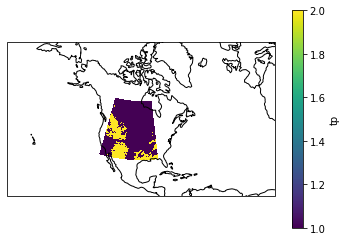

In [28]:
map_proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=45)

p = wetseason.plot(transform=ccrs.PlateCarree(),  # the data's projection  # multiplot settings # for a sensible figsize
             subplot_kws={'projection': map_proj})  # the plot's projection

# We have to set the map's options on all axes
p.axes.coastlines()
p.axes.set_extent([-160, -30, 5, 75])

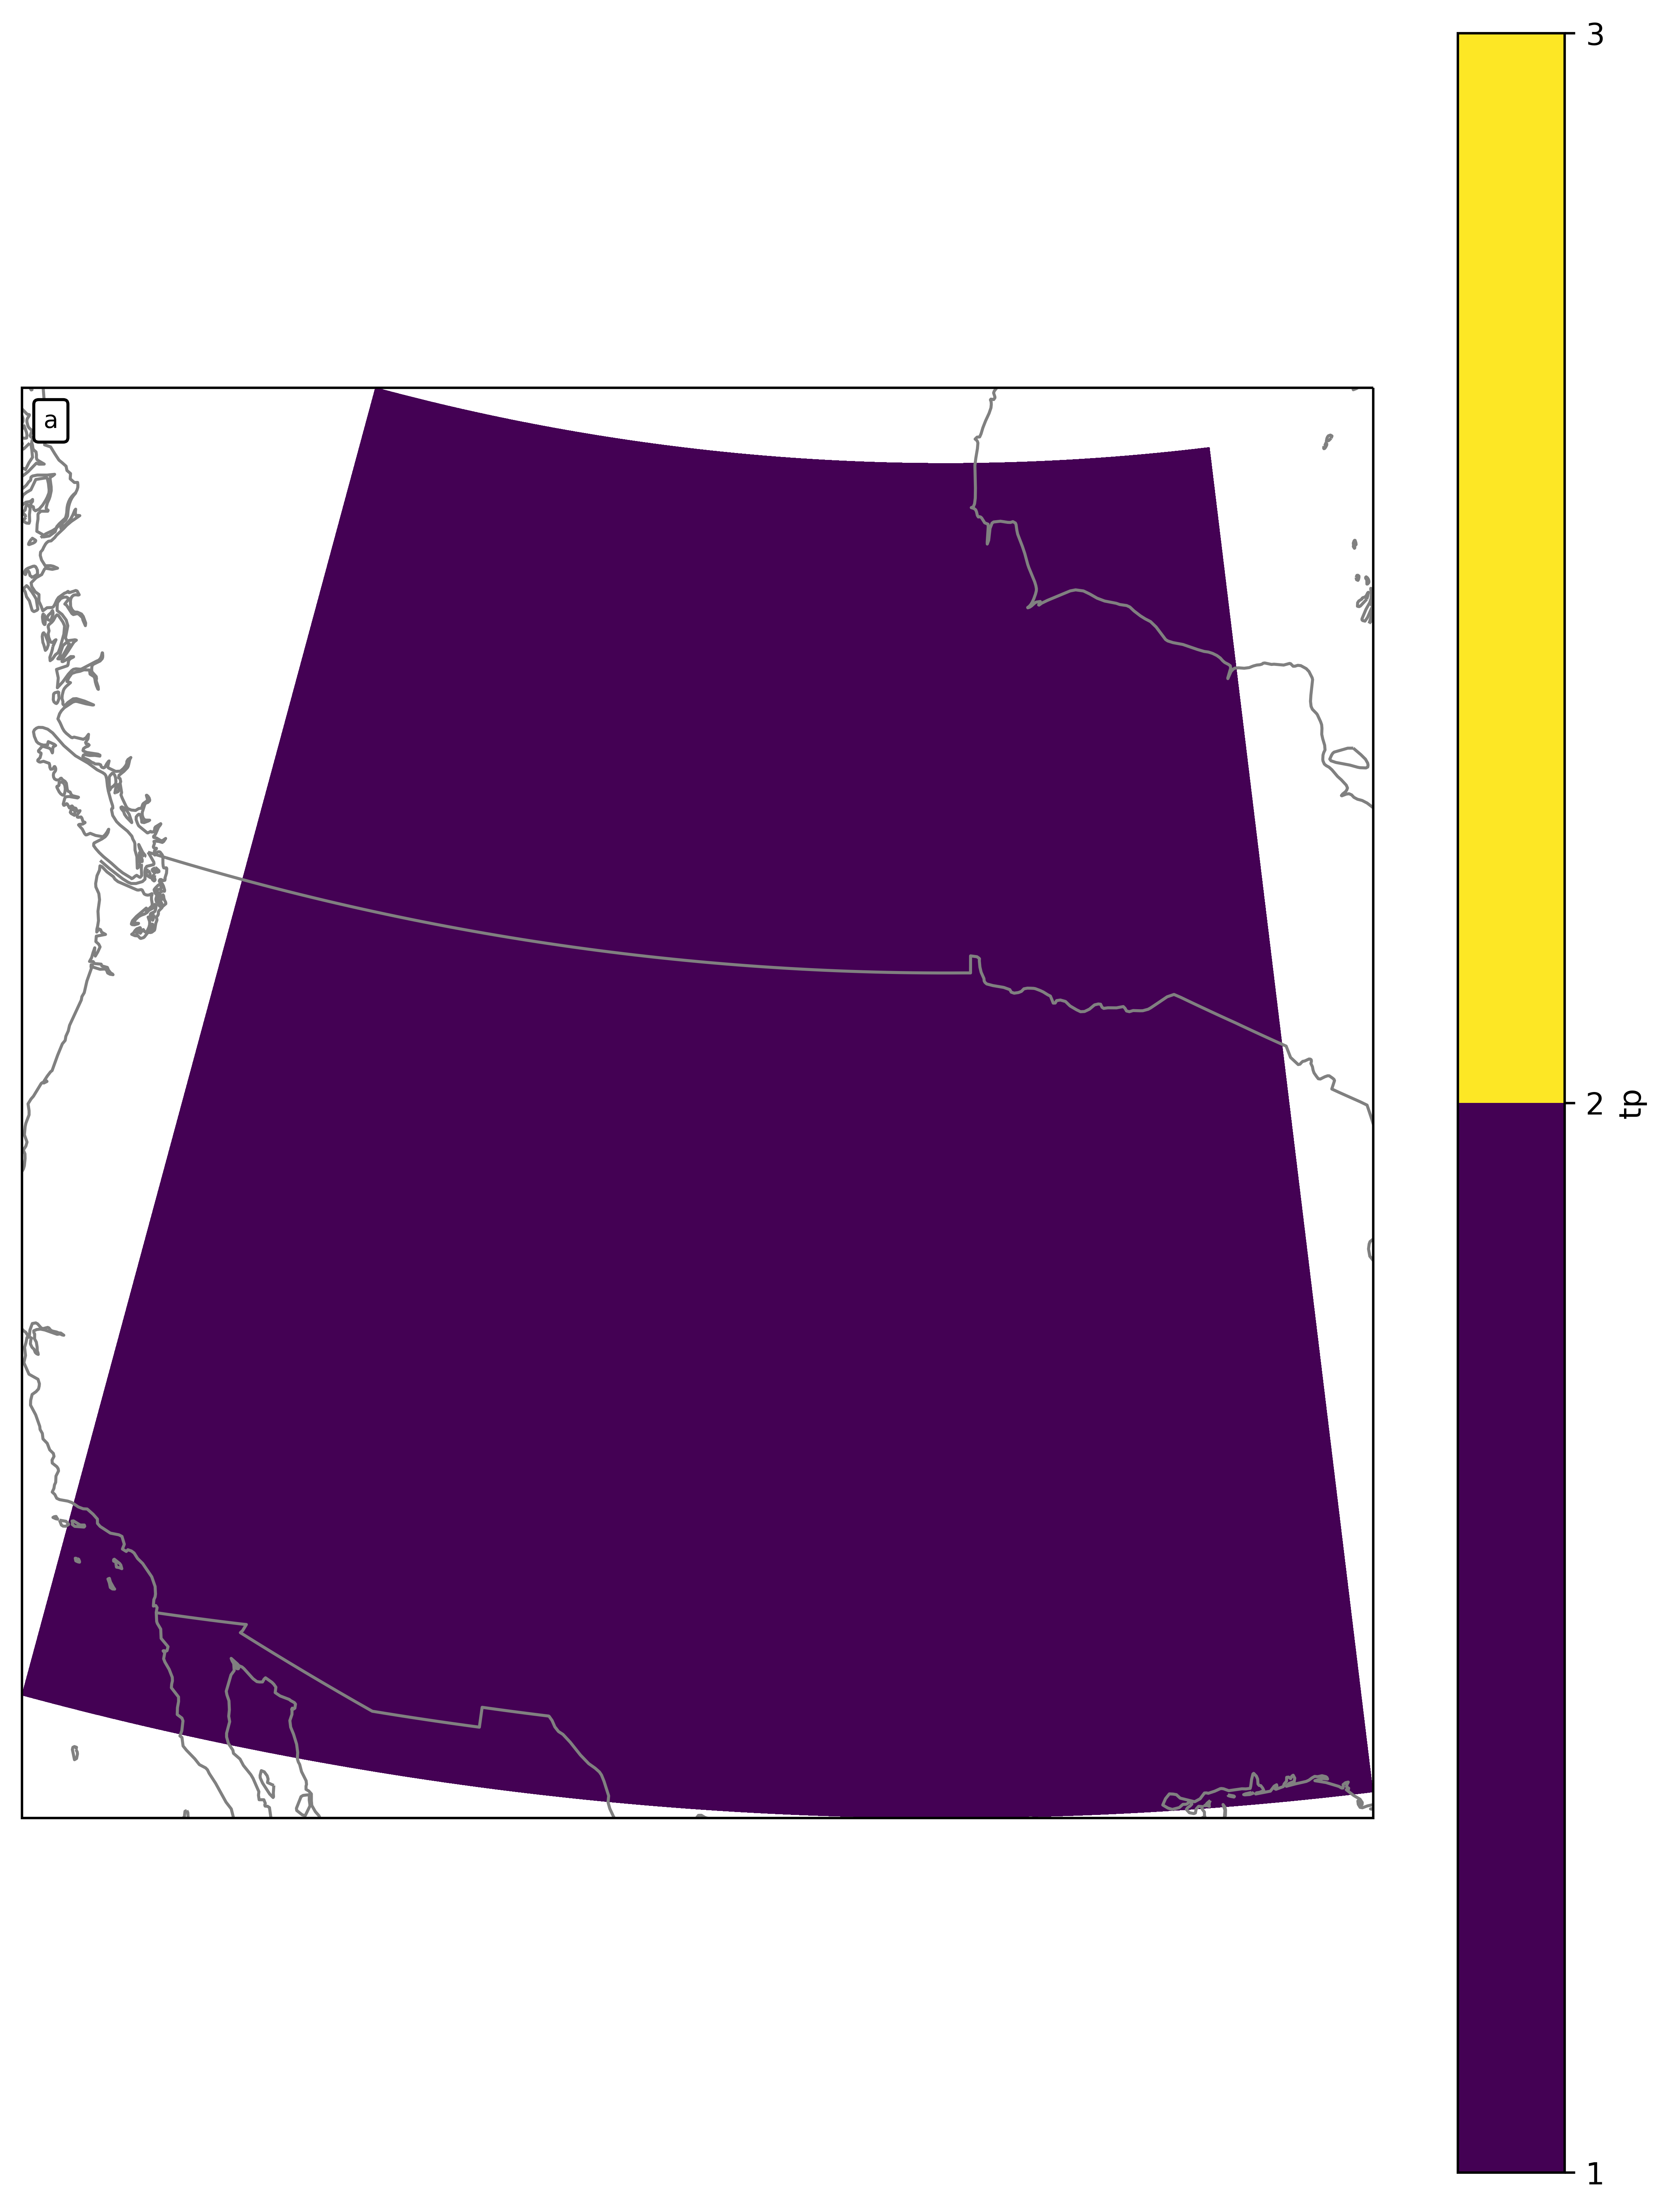

In [20]:
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')
map_proj = ccrs.LambertConformal()
#cmap = mpl.cm.RdBu_r


f, ax1 = plt.subplots(1, 1, figsize=(10, 13), dpi=600, subplot_kw={'projection': map_proj})
wetseason.plot.contourf(ax=ax1, levels=levels, cbar_kwargs={'ticks': levels},transform=ccrs.PlateCarree())


### Setting 1st plot parameters ###
ax1.coastlines(color='grey')
ax1.add_feature(cartopy.feature.BORDERS, color='grey')
#ax1.add_feature(cfeature.STATES, color='grey')
#ax1.set_xticks(np.arange(-180,181, 40))
#ax1.set_yticks(np.arange(-90,91,15))
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
at = AnchoredText("a",
                      loc='upper left', prop=dict(size=8), frameon=True,)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at)